# Twitter Climate Change Sentiment Analysis

- Author: Roelle Kim
- Date: 2022-04-05


# Used Dataset

"Twitter Climate Change Sentiment" at https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset.


# Objective

The goal for the model is to distinguish tweets about climate change into one of the three labels:

- 2: news - factual news about the climate change
- 1: pro - support the belief that climate change is caused by the man-kinds.
- 0: neutral
- -1: anti - refuse the belief that climate change is caused by the man-kinds


# EDA


## Load Packages and Data

Before analyzing data, we need to import required packages and the dataset.


In [270]:
# pip install pydataset

In [271]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn import metrics
from pydataset import data
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle
import json

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [272]:
file_path = "twitter_sentiment_data.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "edqian/twitter-climate-change-sentiment-dataset",
    file_path,
)

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_20437/2489314432.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [273]:
# drop rows where sentiment is 2 (news)
df = df[df["sentiment"] != 2]
df.reset_index(drop=True, inplace=True)

In [274]:
# set up label dataframe for future refrences

label = [
    -1,
    0,
    1,
    #  2
]
labelN = [
    "Anti",
    "Neutral",
    "Pro",
    #   "News"
]
labelDesc = [
    "the tweet does not believe in man-made climate change",
    "the tweet neither supports nor refutes the belief of man-made climate change",
    "the tweet supports the belief of man-made climate change",
    # , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(
    list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"]
)

## Data Dictionary


In [275]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,0,Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X,793125429418815489


The data has a very simple structure with only 2 features. Each row is associated with a unique tweetid, and it shows a tweet pertaining to man-made climate change. The message column shows the content of the tweet and the sentiment column shows the sentiment label that was determined by 3 reviewers.


In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34667 entries, 0 to 34666
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  34667 non-null  int64 
 1   message    34667 non-null  object
 2   tweetid    34667 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 812.6+ KB


There are total of 43949 entries with no null counts.


## Distribution of Sentiments


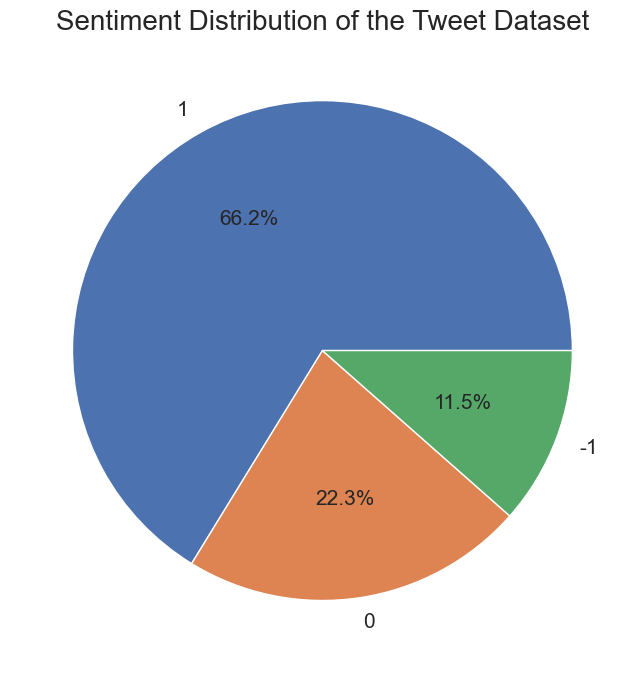

In [277]:
plt.figure(figsize=(7, 7))
plt.pie(
    df.sentiment.value_counts().values,
    labels=df.sentiment.value_counts().index,
    autopct="%2.1f%%",
    textprops={"fontsize": 15},
)
plt.title("Sentiment Distribution of the Tweet Dataset", fontsize=20)
plt.tight_layout()
plt.show()

The pie chart shows the distribution of the data. Majority of tweets are labelled as "1" meaning the positive attitude toward the belief that the climate change is caused by the man-kinds, followed by "2"(news), "0"(neutral), and "-1"(anti).


In [278]:
df.sentiment.value_counts()

sentiment
 1    22962
 0     7715
-1     3990
Name: count, dtype: int64

These are the exact numbers of each sentiment label.


# Data Preparation for Sentiment Analysis

Tweet texts will be transformed and vectorized to be fed into models.


In [279]:
# separate the messages column for transformation.
dfTweets = df["message"]

In [280]:
dfTweets

0        @tiniebeany climate change is an interesting hustle as it was global warming but the p...
1        RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...
2        Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...
3        RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...
4                            Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X
                                                   ...                                            
34662         #AikBaatSuniThi \nGlobal warming has negative effect on the melting down of glaciers
34663    Dear @realDonaldTrump,\nYeah right. Human Mediated Climate Change is a Chinese urban l...
34664          What will your respective parties do to prevent climate change globally? #ZPNDebate
34665    RT @taehbeingextra: i still can$q$t believe this gif of taehyung saved the human race,...
34666    @

## Tokenization

All the tweets are first split into arrays of words.


In [281]:
def createTokenizedArray(sentences):
    """
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    """
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r"\w+")
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [282]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4              [unamshow, awache, kujinga, na, iko, global, warming, https, t, co, mhiflu7m1x]
dtype: object

Each array contains words of individual tweet.


## Stop Word Removal

Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list.


In [283]:
# To get stop words and wordnet for lemmatization.
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


def removeStopWords(tokenList):
    """
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    """
    stopWords = set(stopwords.words("english"))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:
                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if len(word) > 1 and word.isdigit() == False:
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nafis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/nafis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [284]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


You can see the second set of the array now no longer contains some insignificant words such as "is", "an", "as" and "it".


## Lemmatization

English words are often time variations of a root word. Lemmatization reduces words to their base or dictionary form (lemma) by considering the context and part of speech. Unlike stemming, lemmatization produces actual words that exist in the language, which can improve the sentiment algorithm by grouping related words more accurately.


In [285]:
def lemmatizeWords(sentenceArrays):
    """
    Reduces words to their base form (lemma) and rebuilds the sentences.
    :param sentenceArrays: sentences list
    :return: array of sentences with lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    lemmatizedSentences = []
    for sentenceArray in sentenceArrays:
        lemmatizedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            lemmatizedArray.append(lemmatizer.lemmatize(word))  # Add lemmatized word.

        # Convert array back to sentence of lemmatized words.
        delimeter = " "
        sentence = delimeter.join(lemmatizedArray)

        # Append lemmatized sentence to list of sentences.
        lemmatizedSentences.append(sentence)
    return lemmatizedSentences

In [286]:
lemmatizedLi = lemmatizeWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE lemmatization:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER lemmatization:\n{lemmatizedLi[0]}")

Sample sentence BEFORE lemmatization:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER lemmatization:
tiniebeany climate change interesting hustle global warming planet stopped warming yes suv boom


You can see the sentence after lemmatization has been reduced to base word forms. Words like "interesting" become "interesting" (already in base form), "warming" becomes "warming" (gerund form), but other inflected forms would be reduced to their dictionary forms. The array of words has also been converted back to one full sentence.


## Vectorization

Now the lemmatized sentences will be vectorized. It essentially transforms all the existing words into numbers so they can be fed to various big data algorithms.


In [287]:
def vectorizeList(lemmatizedList, ngramRangeStart, ngramRangeEnd):
    """
    Creates a matrix of word vectors.
    :param lemmatizedList: lemmatized sentence list
    :return: matrix of word vectors and vocabulary dictionary
    """
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(lemmatizedList)
    X = cv.transform(lemmatizedList)

    return X, cv.vocabulary_

In [288]:
vectorizedTweets, vectorDictionary = vectorizeList(lemmatizedLi, 1, 1)

Let's look into 2 different sample sentences to understand better what vectorization does


In [289]:
print(f"Sample sentence #1:\n{lemmatizedLi[0]}")
print(f"Sample sentence #2:\n{lemmatizedLi[1]}")

Sample sentence #1:
tiniebeany climate change interesting hustle global warming planet stopped warming yes suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackle climate change http co lkdehj3tnn httã


Notice these 2 sentences have a couple of words in common - "climat", "chang"


In [290]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (1, 58719)>
  Coords	Values
  (0, 8627)	1
  (0, 10652)	1
  (0, 11449)	1
  (0, 21550)	1
  (0, 24378)	1
  (0, 25897)	1
  (0, 39677)	1
  (0, 48230)	1
  (0, 48876)	1
  (0, 50721)	1
  (0, 54581)	1
  (0, 56957)	1
#2 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15 stored elements and shape (1, 58719)>
  Coords	Values
  (0, 7490)	1
  (0, 10652)	1
  (0, 11449)	1
  (0, 11856)	1
  (0, 24205)	1
  (0, 24213)	1
  (0, 30585)	1
  (0, 31125)	1
  (0, 35292)	1
  (0, 43582)	1
  (0, 44263)	1
  (0, 49233)	1
  (0, 51316)	1
  (0, 54652)	1
  (0, 55709)	1


The prints above show the results of 2 sample sentences after being ve. Each vector signifies a unique word in all tweets. For example, we already know they have 2 words in common; therefore, we can see 2 sets of vectors appearing in both sentences - **(0, 12943)** and **(0, 13774)** - which are representations of "climat" and "chang" respectively.


In [291]:
vectorizedTweets.shape

(34667, 58719)

Based on the column size of our vectorized data, we can see there were unique words (no stop words, lemmatized) in 43943 tweets in the dataset.


## Bi-Grams

Using N-Grams, we can group N numbers of words together and analyze their frequencies for specific sentiment rating.


In [292]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf["sentiment"] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf["transformedTweets"]]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = " "
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram": delimiter.join(counterList[i][0]),
            "Occurrences": counterList[i][1],
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [293]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the lemmatized data.
df["transformedTweets"] = lemmatizedLi
dfSub = df[["sentiment", "transformedTweets"]]

We'll look in to top 20 bi-grams for each sentiment label.


### Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)



***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0       climate change         2200
1              http co         1873
2       global warming         1854
3             man made          174
4          change http          148
5     rt stevesgoddard          118
6         warming http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10        made climate           86
11         made global           73
12          warming rt           70
13           change rt           65
14         change real           65
15     warming climate           61
16        warming hoax           60
17         change hoax           51
18        warming data           46
19     warming created           43


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_20437/2879157074.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

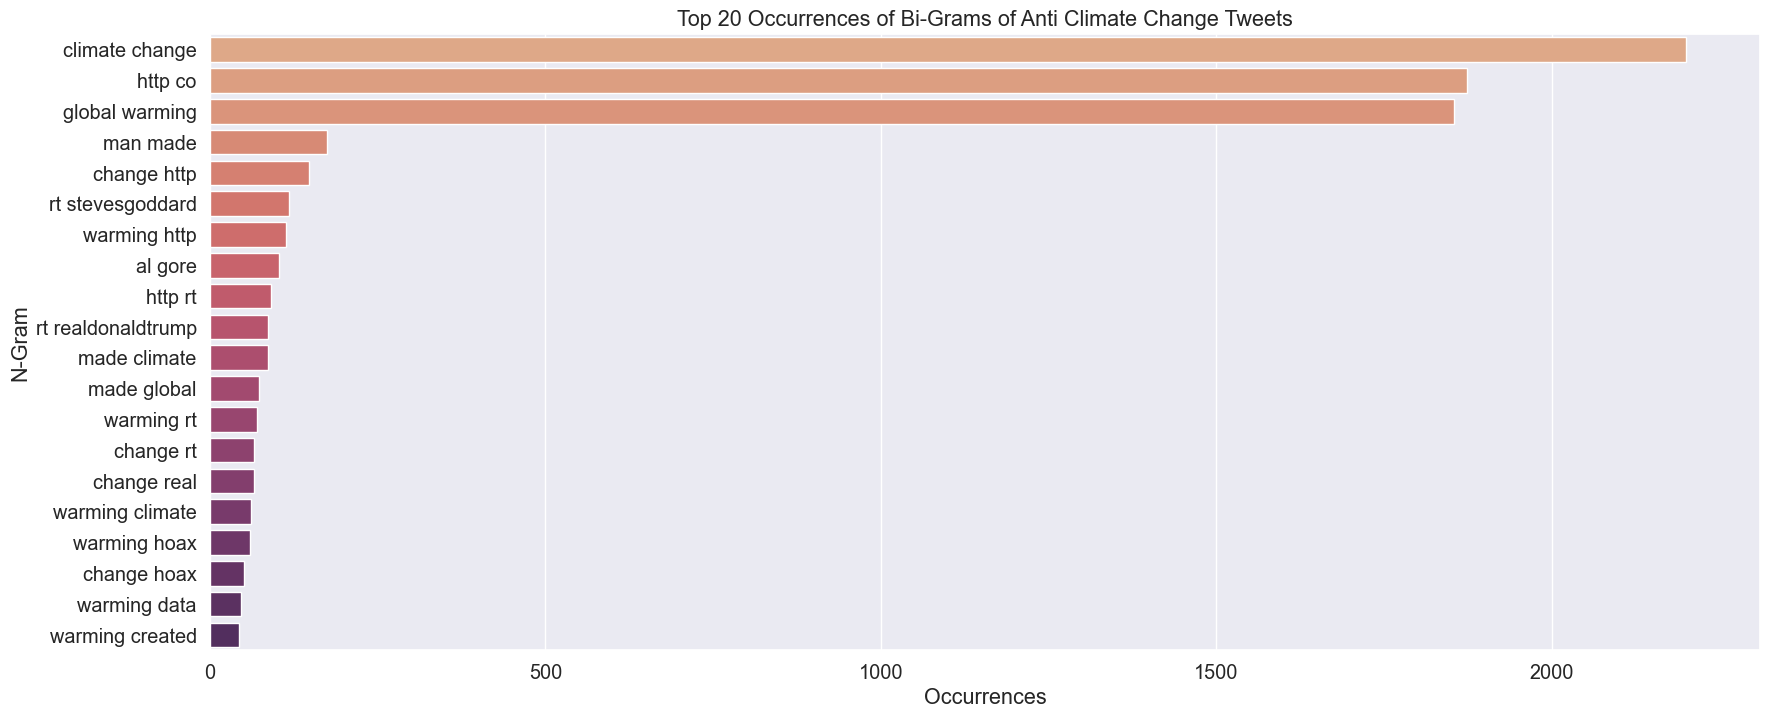

In [294]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

"climat change", "http co" and "global warm" have appeared the most time in the tweets that are refuting climate change is caused by humans. "http co" seems like a link to another website.


### Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (0)



***N-Gram (Sentiment: 0)
             N-Gram  Occurrences
0    climate change         4485
1           http co         3271
2    global warming         3107
3       change http          446
4      warming http          288
5        warming rt          235
6         change rt          216
7      warming real          121
8           http rt          109
9             ðÿ ðÿ           88
10     cause global           86
11     club penguin           82
12      change real           81
13     think global           74
14  believe climate           69
15      change hoax           63
16   believe global           60
17     donald trump           59
18     talk climate           55
19    think climate           53


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_20437/2155537556.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

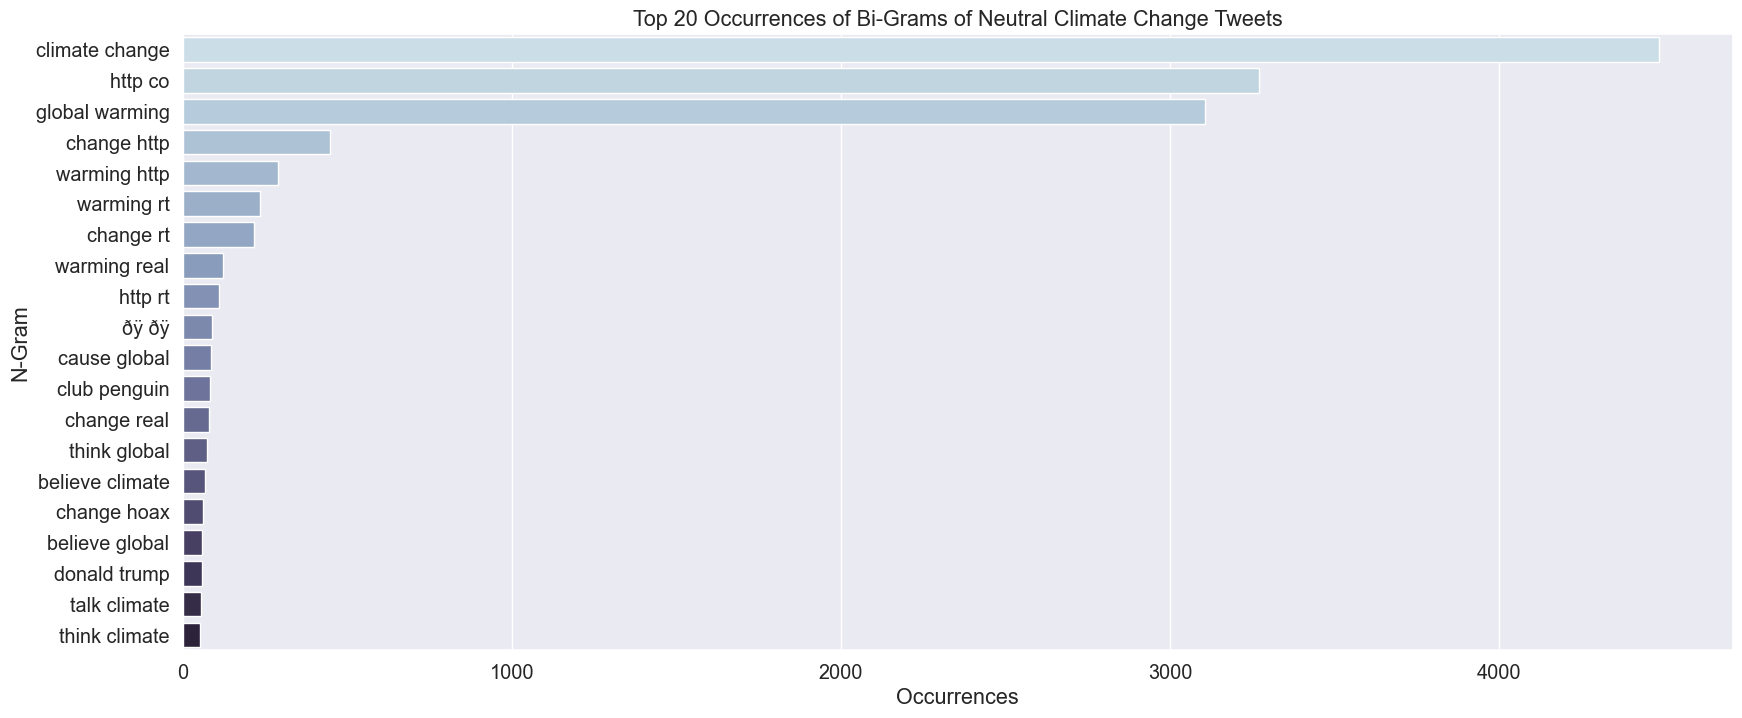

In [295]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25"
)

Neutral tweets also have very similar patterns to the anti tweets. "climat chang", "http co" and "global warm" are the top 3 followed by "chang http", "warm http", "warm rt" and "chang rt". "rt" is short for "re-tweet".
The only difference may be notable here is that "man made" was not mentioned as the top 20 occurrences in the neutral tweets.


### Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets (1)



***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0             climate change        19112
1                    http co        12378
2             global warming         3850
3                change http         2798
4            believe climate         1292
5                    http rt          788
6              change denier          711
7                change real          679
8              fight climate          636
9                  going die          539
10           husband believe          511
11            thinking going          510
12               die husband          510
13        rt stephenschlegel          507
14  stephenschlegel thinking          507
15                co sjofonã          506
16              warming http          482
17                 change rt          474
18                sjofonã rt          435
19             rt sensanders          423


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_20437/3802794499.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

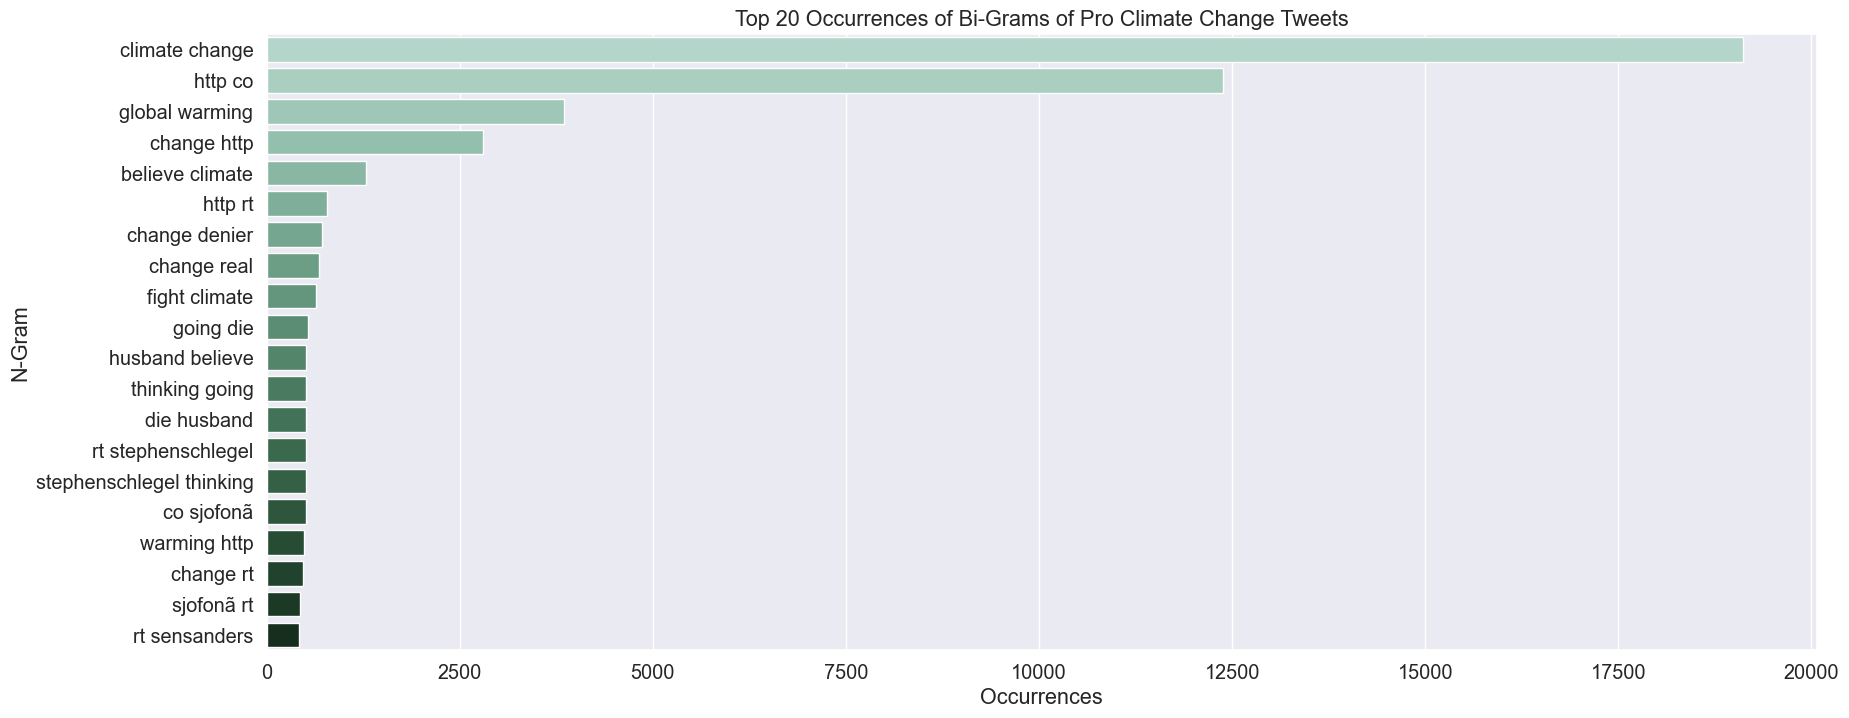

In [296]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8"
)

Again, the top 3 bi-grams are "climat chang", "http co" and "global warm" for pro climate change tweets. A considerable size of tweets are containing "believ climat" and "fight climat". Perhaps people were explicitly expressing that they are "believing in climate change" or "fighting for the climate change".


## Tri-Grams

Let's try tri-grams and see if it finds more meaningful combinations of words than bi-grams.


In [297]:
SIZE = 3

## Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)



***N-Gram (Sentiment: -1)
                     N-Gram  Occurrences
0       climate change http          146
1            change http co          136
2       global warming http          112
3           warming http co          105
4       made climate change           82
5          man made climate           78
6       made global warming           71
7         global warming rt           70
8           man made global           67
9       climate change real           65
10      global warming hoax           60
11        climate change rt           60
12   global warming climate           59
13      climate change hoax           51
14   warming climate change           50
15      global warming data           45
16   global warming created           43
17   concept global warming           42
18  warming created chinese           42
19      global warming scam           41


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_20437/2990623308.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

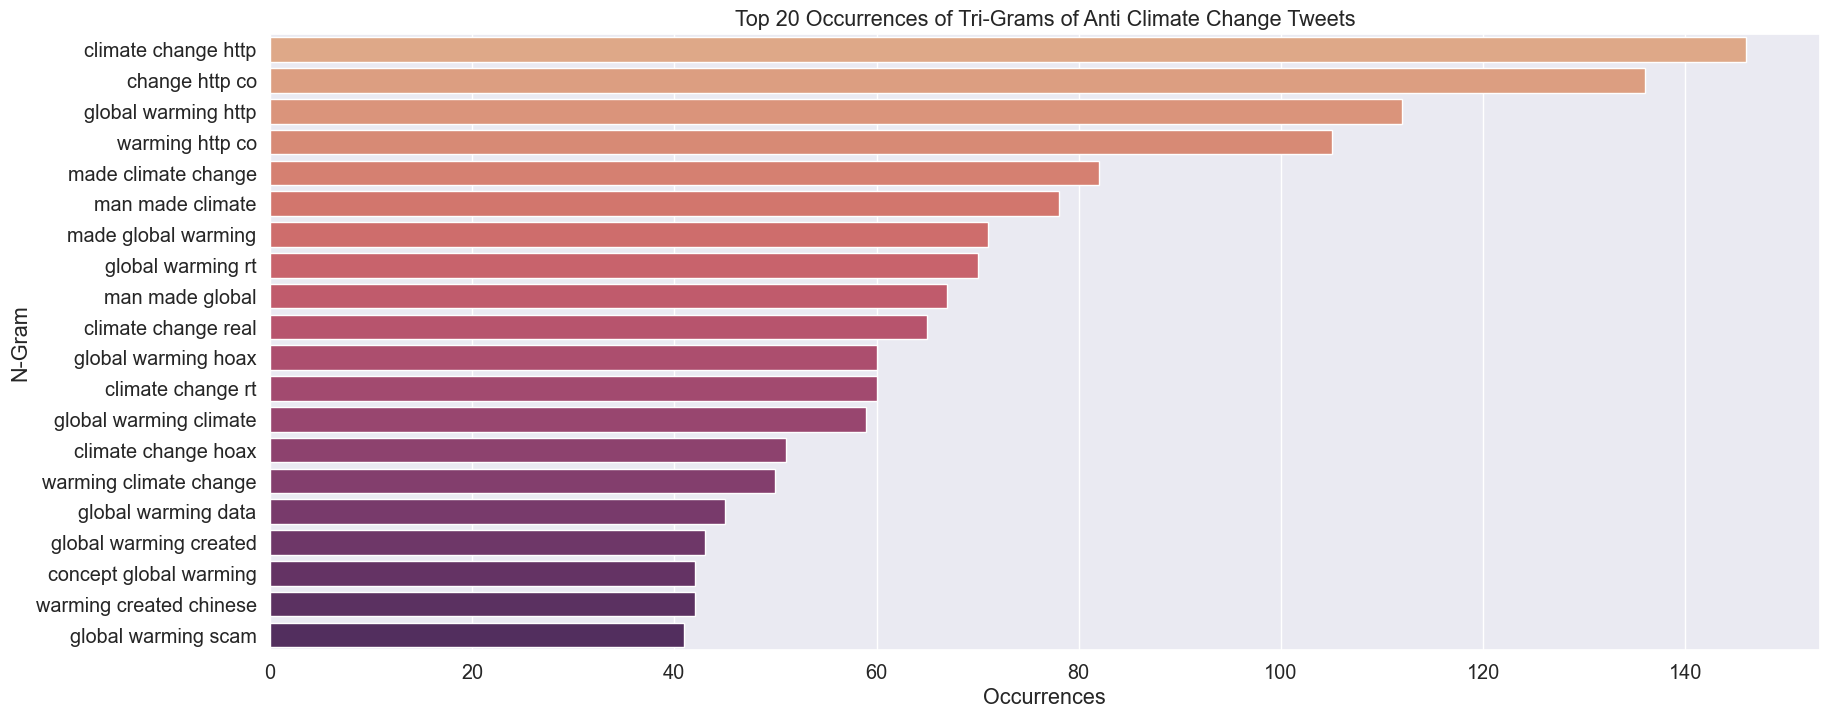

In [298]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

### Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)



***N-Gram (Sentiment: 0)
                    N-Gram  Occurrences
0      climate change http          443
1           change http co          423
2      global warming http          288
3          warming http co          279
4        global warming rt          235
5        climate change rt          214
6      global warming real          121
7     cause global warming           86
8      climate change real           81
9     think global warming           73
10  believe climate change           69
11     climate change hoax           63
12  believe global warming           60
13     talk climate change           53
14    think climate change           52
15      amp climate change           51
16      climate change amp           49
17                ðÿ ðÿ ðÿ           49
18    fight climate change           48
19   climate change global           45


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_20437/2904435185.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

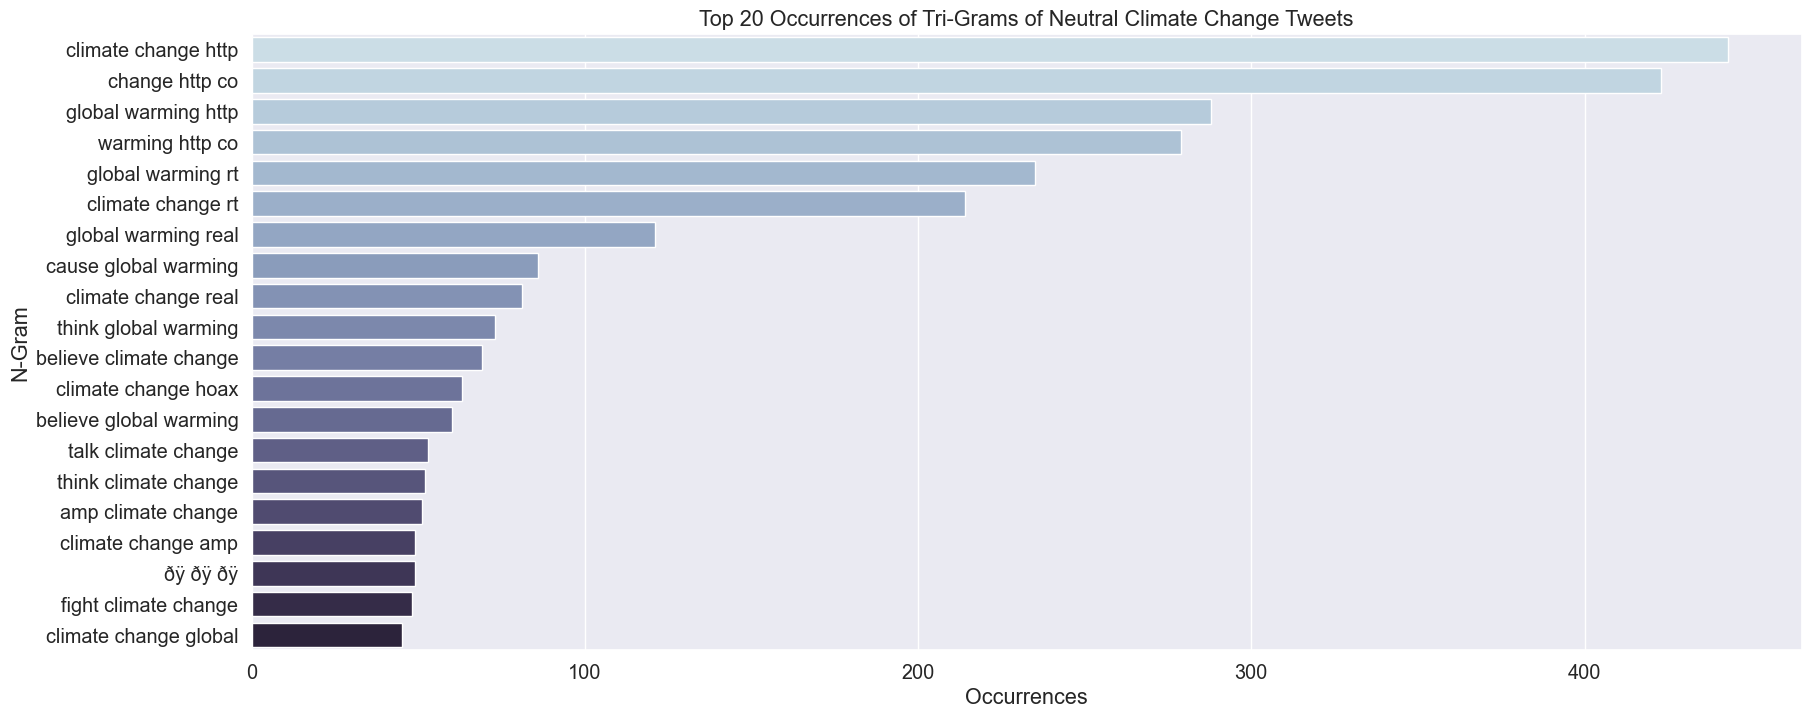

In [299]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25"
)

### Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)



***N-Gram (Sentiment: 1)
                            N-Gram  Occurrences
0              climate change http         2787
1                   change http co         2635
2           believe climate change         1287
3            climate change denier          711
4              climate change real          679
5             fight climate change          629
6          husband believe climate          511
7               thinking going die          510
8                going die husband          510
9              die husband believe          510
10     rt stephenschlegel thinking          507
11  stephenschlegel thinking going          507
12                 http co sjofonã          506
13             global warming http          480
14               climate change rt          464
15                 warming http co          458
16                   co sjofonã rt          435
17             global warming real          338
18            think climate change          321
19      sjofon

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_20437/4132814696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

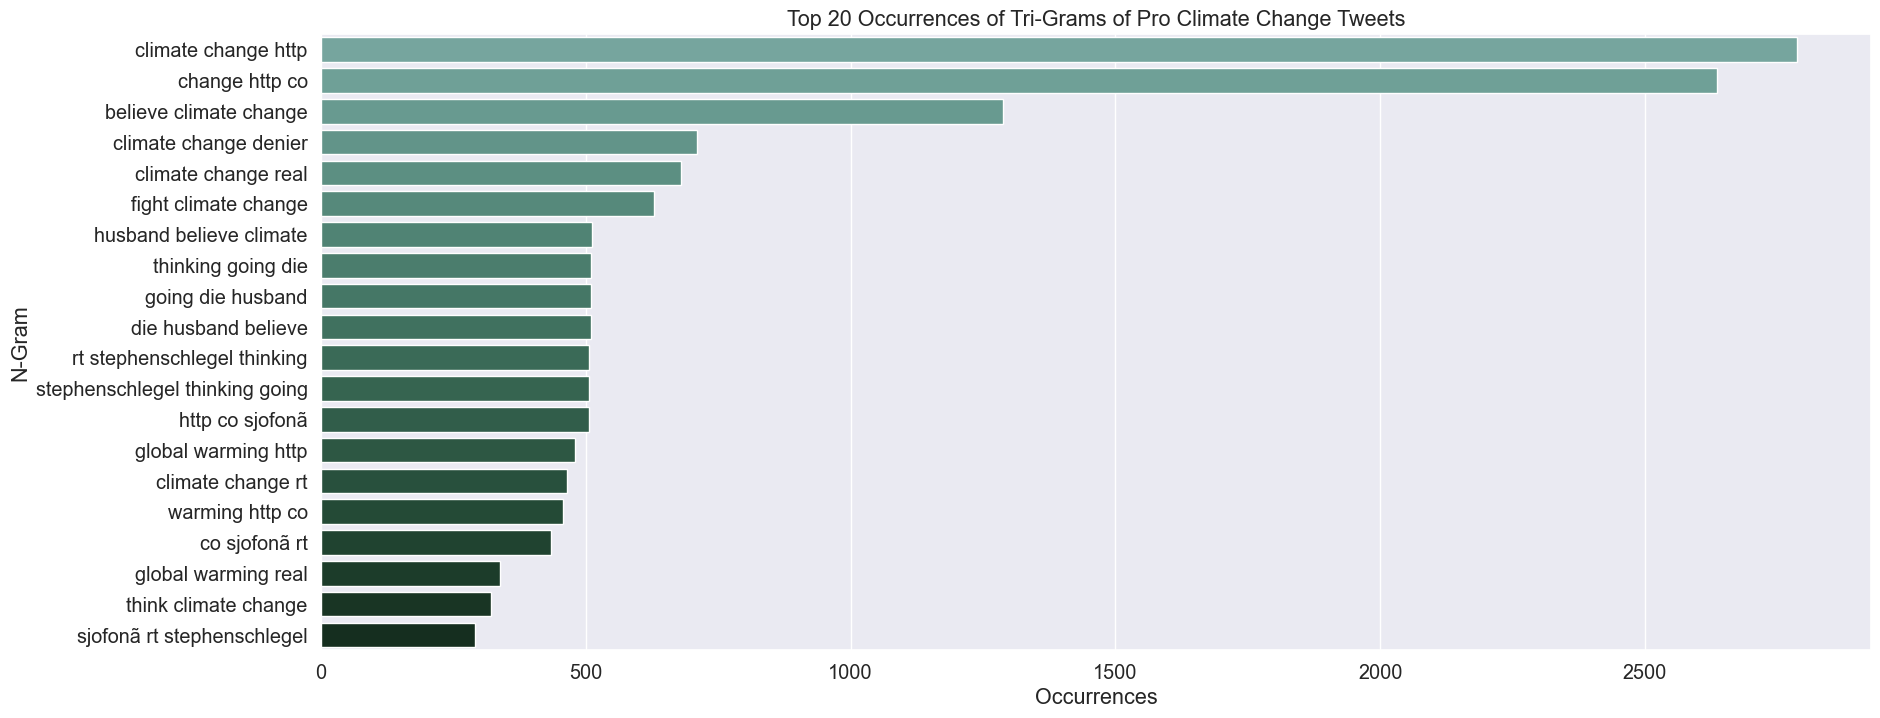

In [300]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")

Overall, it seems like tri-grams grab more accurate actions or emotions associated with climate change or global warming.


# Model Development

Various models will be built to predict the sentiment of tweets pertaining to climate change.


In [301]:
def evaluateModel(model, X_test, y_test, title):
    """
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    """
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average="weighted")
    precision = metrics.precision_score(y_test, predictions, average="weighted")
    f1 = metrics.f1_score(y_test, predictions, average="weighted")

    clsScoreDict = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [302]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__

    # Create training set with 80% of data and test set with 20% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.8, random_state=42)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [303]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    """
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    """
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = [
        "Actual -1",
        "Actual 0",
        "Actual 1",
        #  'Actual 2',
    ]
    Cols = [
        "Pred -1",
        "Pred 0",
        "Pred 1",
        # 'Pred 2'
    ]
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap="Blues", annot=True, fmt="g")
    bottom, top = ax.get_ylim()
    ax.set(title="Climate Change Sentiment")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")

In [304]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(
    lemmatizedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [305]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(
    lemmatizedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [306]:
# unigram & bi-gram vectorization
NGRAM_RANGE_START = 1
NGRAM_RANGE_END = 2

vectorizedTweets12, vectorDictionary12 = vectorizeList(
    lemmatizedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [307]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(
    lemmatizedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

## 1. Logistic Regression


In [308]:
model = LogisticRegression(random_state=42)


*** LogisticRegression ***
Accuracy:  0.7760311508508797
Precision: 0.7648777636558926
Recall:    0.7760311508508797
F1:        0.7649819459690633



[[ 422  165  237]
 [  79  774  685]
 [  69  318 4185]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


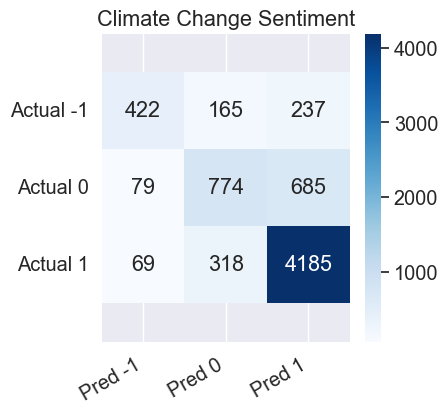

In [309]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Logistic Regression



*** LogisticRegression ***
Accuracy:  0.7470435535044707
Precision: 0.739637766073399
Recall:    0.7470435535044707
F1:        0.7193443647032769



[[ 259  159  406]
 [  34  620  884]
 [  17  254 4301]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


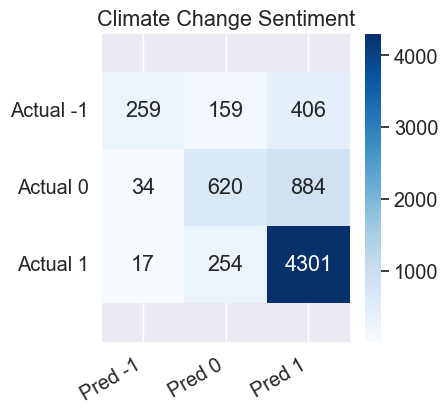

In [310]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(
    vectorizedTweets2, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Logistic Regression



*** LogisticRegression ***
Accuracy:  0.7122872800692241
Precision: 0.7053192789392599
Recall:    0.7122872800692241
F1:        0.6594114871367548



[[ 183   87  554]
 [  20  364 1154]
 [  16  164 4392]]


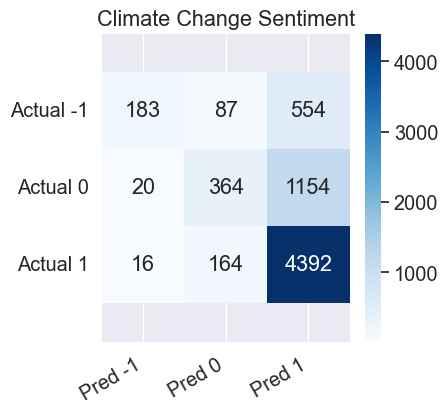

In [311]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(
    vectorizedTweets3, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Logistic Regression



*** LogisticRegression ***
Accuracy:  0.7851168156907989
Precision: 0.7756823858164154
Recall:    0.7851168156907989
F1:        0.771700491741711



[[ 415  154  255]
 [  61  765  712]
 [  45  263 4264]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


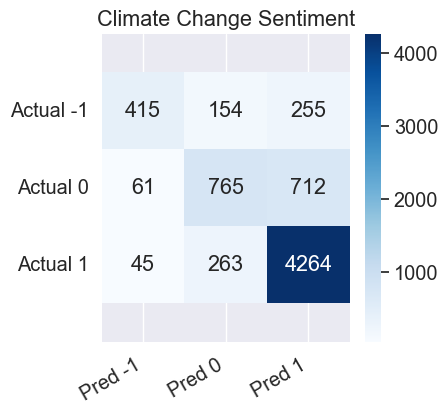

In [312]:
X_test, y_test, y_predicted, lrScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Logistic Regression

Note that I was not able to vectorize data ranging from 1 to 3-gram due to memory issue on my device.



*** LogisticRegression ***
Accuracy:  0.7405537929045284
Precision: 0.7304264302907462
Recall:    0.7405537929045284
F1:        0.7112462812291023



[[ 237  180  407]
 [  37  607  894]
 [  19  262 4291]]


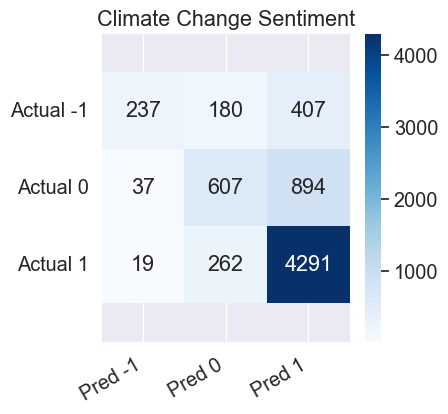

In [313]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(
    vectorizedTweets23, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### N-gram Comparisons

We have built different vectorized sentences using different ranges of N-grams (1, 2, 3, 1-2 combined, and 2 to 3). Each of them was fed to a logistic regression model and evaluated based on classification scores such as accuracy, precision, recall and F1. In this section, we will compare all the scores and see what N-gram has worked the best.


In [314]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["Unigram"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf12 = pd.DataFrame(lrScoreDict12, index=["Unigram & Bi-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat(
    [lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf12, lsScoreDf23]
)
lsScoreComparisonDf

,accuracy,recall,precision,f1
Unigram,0.776031,0.776031,0.764878,0.764982
Bi-gram,0.747044,0.747044,0.739638,0.719344
Tri-gram,0.712287,0.712287,0.705319,0.659411
Unigram & Bi-gram,0.785117,0.785117,0.775682,0.771700
Bi-gram and Tri-gram,0.740554,0.740554,0.730426,0.711246


Logistic regression has worked the best when no N-gram was used to vectorize the sentences. Let's see if we can improve the model even further using different classification models.


## 2. Random Forest Classifier


In [315]:
model = RandomForestClassifier(random_state=42)


*** RandomForestClassifier ***
Accuracy:  0.751225843668878
Precision: 0.7452034032910642
Recall:    0.751225843668878
F1:        0.7247771812435654



Accuracy:  0.751225843668878
Precision: 0.7452034032910642
Recall:    0.751225843668878
F1:        0.7247771812435654



[[ 266  154  404]
 [  27  642  869]
 [  23  248 4301]]
[[ 266  154  404]
 [  27  642  869]
 [  23  248 4301]]


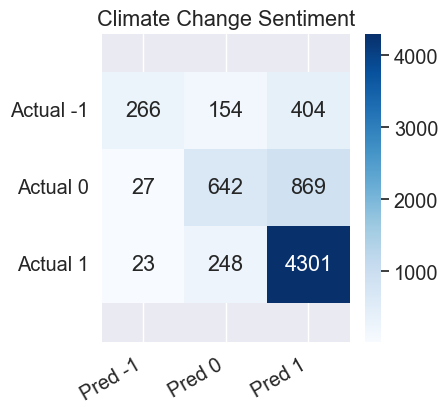

In [316]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 3. Multinomial Naive Bayes


In [317]:
model = MultinomialNB()


*** MultinomialNB ***
Accuracy:  0.748774156331122
Precision: 0.7404703062355524
Recall:    0.748774156331122
F1:        0.7128262237281857



[[ 258  109  457]
 [  59  524  955]
 [  19  143 4410]]


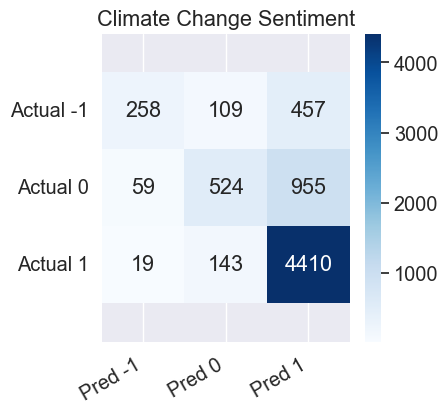

In [318]:
X_test, y_test, y_predicted, nbScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Multinomial Naive Bayes



*** MultinomialNB ***
Accuracy:  0.707816556100375
Precision: 0.712628369714845
Recall:    0.707816556100375
F1:        0.7096570845185862



[[ 404  200  220]
 [ 164  798  576]
 [ 159  707 3706]]


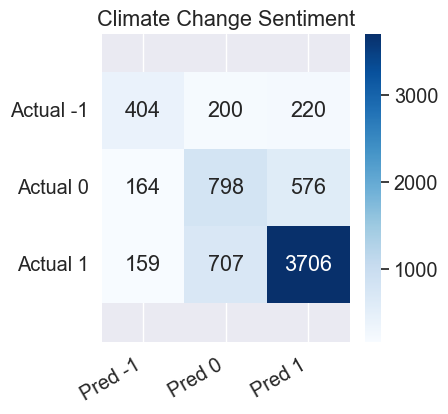

In [319]:
X_test, y_test, y_predicted, nbScoreDict2 = modelAndPredict(
    vectorizedTweets2, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Multinomial Naive Bayes



*** MultinomialNB ***
Accuracy:  0.5672050764349582
Precision: 0.6708457790159603
Recall:    0.5672050764349582
F1:        0.5954921832506332



[[ 442  252  130]
 [ 340  829  369]
 [ 688 1222 2662]]
Accuracy:  0.5672050764349582
Precision: 0.6708457790159603
Recall:    0.5672050764349582
F1:        0.5954921832506332



[[ 442  252  130]
 [ 340  829  369]
 [ 688 1222 2662]]


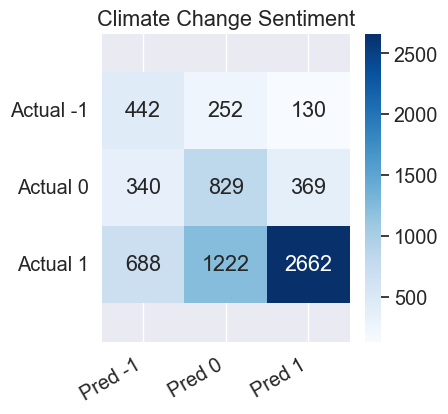

In [320]:
X_test, y_test, y_predicted, nbScoreDict3 = modelAndPredict(
    vectorizedTweets3, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Multinomial Naive Bayes



*** MultinomialNB ***
Accuracy:  0.7666570522065186
Precision: 0.7563644240813323
Recall:    0.7666570522065186
F1:        0.7434002075980694



[[ 326  140  358]
 [  67  651  820]
 [  18  215 4339]]


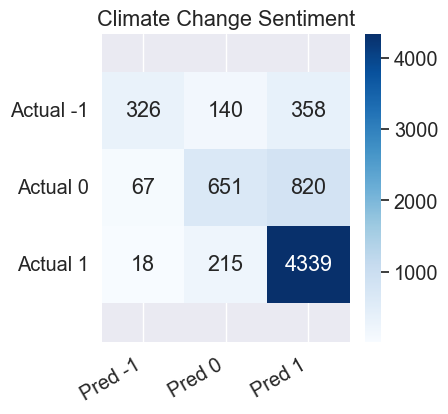

In [321]:
X_test, y_test, y_predicted, nbScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Multinomial Naive Bayes



*** MultinomialNB ***
Accuracy:  0.6289299105855206
Precision: 0.6987889763653088
Recall:    0.6289299105855206
F1:        0.6504117194109749



[[ 504  198  122]
 [ 343  813  382]
 [ 517 1011 3044]]


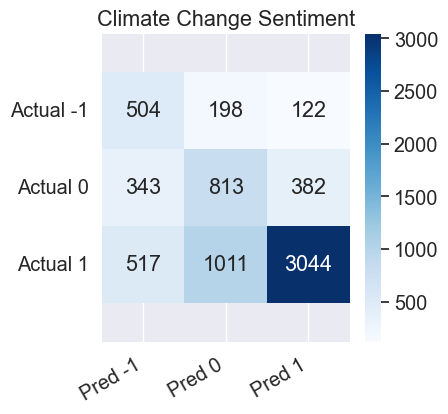

In [322]:
X_test, y_test, y_predicted, nbScoreDict23 = modelAndPredict(
    vectorizedTweets23, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 4. Ridge Classifier


In [323]:
model = RidgeClassifier(random_state=42)


*** RidgeClassifier ***
Accuracy:  0.7672339198154023
Precision: 0.7561286700924346
Recall:    0.7672339198154023
F1:        0.7560389951667619



[[ 412  167  245]
 [  77  754  707]
 [  64  354 4154]]


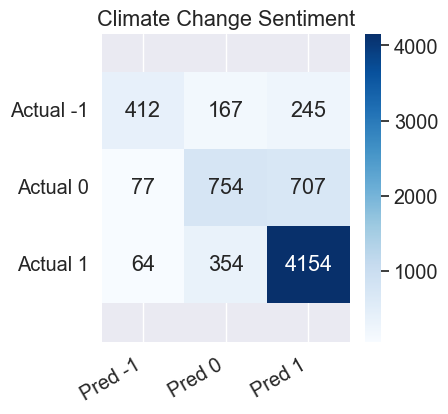

In [324]:
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Ridge Classifier



*** RidgeClassifier ***
Accuracy:  0.7468993366022498
Precision: 0.7362640655270405
Recall:    0.7468993366022498
F1:        0.7269261213251249



[[ 299  177  348]
 [  51  676  811]
 [  30  338 4204]]


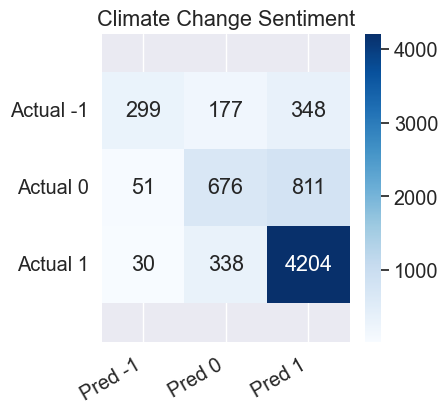

In [325]:
X_test, y_test, y_predicted, ridgeScoreDict2 = modelAndPredict(
    vectorizedTweets2, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Ridge Classifier



*** RidgeClassifier ***
Accuracy:  0.7144505336025382
Precision: 0.6972365260236241
Recall:    0.7144505336025382
F1:        0.679175672985063



[[ 224  134  466]
 [  40  487 1011]
 [  29  300 4243]]


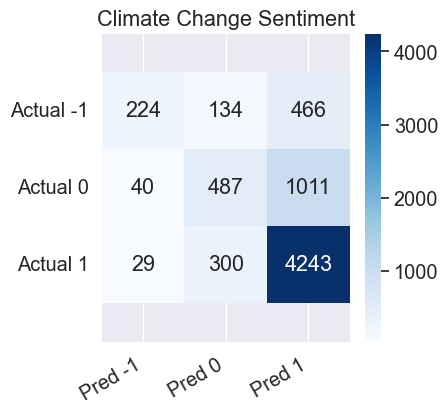

In [326]:
X_test, y_test, y_predicted, ridgeScoreDict3 = modelAndPredict(
    vectorizedTweets3, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Ridge Classifier



*** RidgeClassifier ***
Accuracy:  0.7858379002019037
Precision: 0.7775033011425925
Recall:    0.7858379002019037
F1:        0.7748154323451031



[[ 420  168  236]
 [  64  803  671]
 [  41  305 4226]]


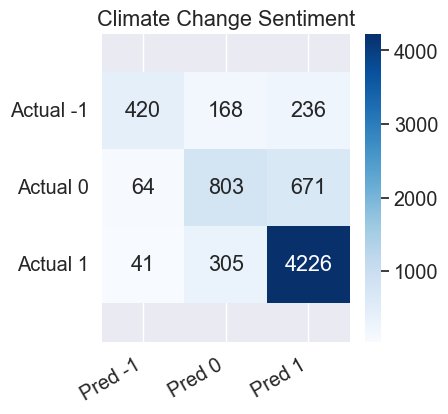

In [327]:
X_test, y_test, y_predicted, ridgeScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Ridge Classifier



*** RidgeClassifier ***
Accuracy:  0.7431496971445053
Precision: 0.7346043525775463
Recall:    0.7431496971445053
F1:        0.7228332637743211



[[ 280  184  360]
 [  41  686  811]
 [  28  357 4187]]


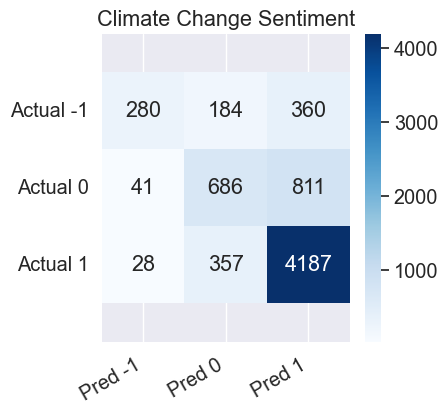

In [328]:
X_test, y_test, y_predicted, ridgeScoreDict23 = modelAndPredict(
    vectorizedTweets23, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

# Model Comparisons


In [329]:
# Logistic Regression scores for different N-grams
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression (Unigram)"])
lrScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Logistic Regression (Bi-gram)"])
lrScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Logistic Regression (Tri-gram)"])
lrScoreDf12 = pd.DataFrame(lrScoreDict12, index=["Logistic Regression (Unigram & Bi-gram)"])
lrScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Logistic Regression (Bi-gram & Tri-gram)"])

# Random Forest scores for different N-grams
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest (Unigram)"])

# Multinomial Naive Bayes scores for different N-grams
nbScoreDf = pd.DataFrame(nbScoreDict, index=["Multinomial Naive Bayes (Unigram)"])
nbScoreDf2 = pd.DataFrame(nbScoreDict2, index=["Multinomial Naive Bayes (Bi-gram)"])
nbScoreDf3 = pd.DataFrame(nbScoreDict3, index=["Multinomial Naive Bayes (Tri-gram)"])
nbScoreDf12 = pd.DataFrame(nbScoreDict12, index=["Multinomial Naive Bayes (Unigram & Bi-gram)"])
nbScoreDf23 = pd.DataFrame(nbScoreDict23, index=["Multinomial Naive Bayes (Bi-gram & Tri-gram)"])

# Ridge Classifier scores for different N-grams
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classifier (Unigram)"])
ridgeScoreDf2 = pd.DataFrame(ridgeScoreDict2, index=["Ridge Classifier (Bi-gram)"])
ridgeScoreDf3 = pd.DataFrame(ridgeScoreDict3, index=["Ridge Classifier (Tri-gram)"])
ridgeScoreDf12 = pd.DataFrame(ridgeScoreDict12, index=["Ridge Classifier (Unigram & Bi-gram)"])
ridgeScoreDf23 = pd.DataFrame(ridgeScoreDict23, index=["Ridge Classifier (Bi-gram & Tri-gram)"])

# Combine all model results
clsCompDf = pd.concat([
    # Logistic Regression
    lrScoreDf, lrScoreDf2, lrScoreDf3, lrScoreDf12, lrScoreDf23,
    # Random Forest
    rfScoreDf,
    # Multinomial Naive Bayes
    nbScoreDf, nbScoreDf2, nbScoreDf3, nbScoreDf12, nbScoreDf23,
    # Ridge Classifier
    ridgeScoreDf, ridgeScoreDf2, ridgeScoreDf3, ridgeScoreDf12, ridgeScoreDf23
])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending=False)

,accuracy,recall,precision,f1
Ridge Classifier (Unigram & Bi-gram),0.785838,0.785838,0.777503,0.774815
Logistic Regression (Unigram & Bi-gram),0.785117,0.785117,0.775682,0.771700
Logistic Regression (Unigram),0.776031,0.776031,0.764878,0.764982
Ridge Classifier (Unigram),0.767234,0.767234,0.756129,0.756039
Multinomial Naive Bayes (Unigram & Bi-gram),0.766657,0.766657,0.756364,0.743400
Random Forest (Unigram),0.751226,0.751226,0.745203,0.724777
Multinomial Naive Bayes (Unigram),0.748774,0.748774,0.740470,0.712826
Logistic Regression (Bi-gram),0.747044,0.747044,0.739638,0.719344
Ridge Classifier (Bi-gram),0.746899,0.746899,0.736264,0.726926
Ridge Classifier (Bi-gram & Tri-gram),0.743150,0.743150,0.734604,0.722833


We can compare the performance of our four selected models: **Logistic Regression**, **Random Forest Classifier**, **Multinomial Naive Bayes**, and **Ridge Classifier** based on their accuracy, precision, recall, and F1 scores.


# Binary File Export

To reuse the built model to predict other tweets, we will be saving the model as a binary file.


In [330]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.75, random_state=42)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if not path.exists("./model"):
        makedirs("./model")
    pickle.dump(
        clfModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb")
    )

    # load model
    loadedModel = pickle.load(
        open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb")
    )

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [331]:
model = LogisticRegression(random_state=42)


*** LogisticRegression ***
Accuracy:  0.7752394138686973
Precision: 0.7640691705308805
Recall:    0.7752394138686973
F1:        0.7646796011147307



[[ 532  201  301]
 [ 102  944  839]
 [  89  416 5243]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


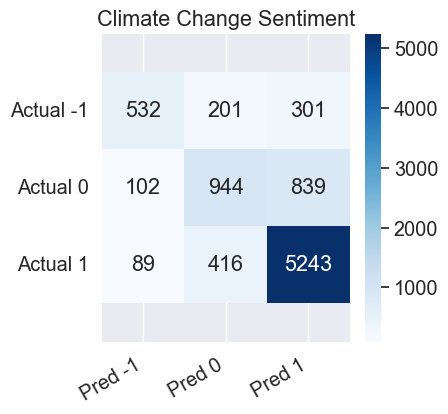

In [332]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

We also need a reference to vectors for each word found in the dataset. The word dictionary will be exported as a JSON file. Each unique word in the dataset is associated with its vector value.


In [333]:
# with open("wordDictionary.json", "w") as fp:
#     json.dump(vectorDictionary, fp)